<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/Quick_Analysis_wi_dpi_all_staff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary and Education in Wisconsin

This notebook is intended to describe analysis on salaries of teachers within the Wisconsin Department of Public Instruction.


## Data Download



https://dpi.wi.gov/cst/data-collections/staff/published-data

In [0]:
!pip install --upgrade google-cloud-storage

In [0]:
from google.cloud import storage

Set values for project and datasets we are working with

In [0]:
project_id='wi-dpi-010'
raw_data_bucket_name='landing-009'
source_name='all_staff_report'
year='2017_2018'
filename='AllStaffReportPublic__05232019_205939.csv'
full_filename=raw_data_bucket_name + '/' + source_name + '/' + year + '/' + filename


Authenticate to GCP

In [0]:
from google.colab import auth
auth.authenticate_user()

## Data Preparation

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
import io

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')

### Functions

In [0]:
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

In [0]:
def prep_name(val):
  """
  Take name and make first leter capital; rest lowercase
  """
  new_val  = val.lower().title()
  return new_val

### Load Data

In [0]:
storage_client = storage.Client(project=project_id)
bucket = storage_client.get_bucket(raw_data_bucket_name)
blob = bucket.get_blob('all_staff_report/2017_2018/AllStaffReportPublic__05232019_205939.csv')
data = blob.download_as_string()

In [0]:
df=pd.read_csv(io.StringIO(data.decode('utf-8')))

In [18]:
df.head()

,Research Id,School Year,Last Name,First Name,Entity ID,Gender,RaceEthnicity,Birth Year,Contract Hire Agency,Contract High Degree,Contract Days,Contract Local Experience,Contract Total Experience,Total Salary,Total Fringe,Assignment Area,Assignment Staff Category,Position Classification,Hire Agency,Assignment Hire Agency Type,Assignment Work Agency,Work Agency Type,Assignment Work School,Assignment Work CESA Number,Assignment Work County,Assignment Work School Level,Assignment Position,Assignment FTE,Assignment Grades Served,Assignment Long Term Substitute,Assignment Bilingual Program,Assignment Alternative Program,Assignment Subcontracted,Assignment Requires DPI License,School Mailing Street Address,School Mailing Po Box,School Mailing City,School Mailing State,School Mailing Zip Code,District Mailing Street Address,District Mailing Po Box,District Mailing City,District Mailing State,District Mailing Zip Code
0,114343,2018,Aaberg,Nicole,NaN,F,W - White,1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9068 - Clerical/Support Staff,3 - Support - Regular Education,Other,4144 - Oregon School District,03 - Public school district,4144 - Oregon School District,03 - Public school district,0200 - Rome Corners Intermediate,2.0,13 - Dane,5 - Middle School,98 - Other Support Staff,1.0,NaN,NaN,NaN,NaN,N,N,1111 S Perry Pkwy,NaN,Oregon,WI,53575.0,123 E Grove St,NaN,Oregon,WI,53575
1,41630,2018,Aabye,Carrie,11397.0,F,W - White,1966,3619 - Milwaukee School District,5 - Master's degree,191.0,20.0,20.0,"$77,701","$30,023",0050 - Elementary - All Subjects,1 - Professional - Regular Education,Teachers,3619 - Milwaukee School District,03 - Public school district,3619 - Milwaukee School District,03 - Public school district,0295 - Zablocki Elementary,1.0,40 - Milwaukee,6 - Elementary School,53 - Teacher,1.0,PK,N,N,N,N,Y,1016 W Oklahoma Ave,NaN,Milwaukee,WI,53215.0,NaN,2181.0,Milwaukee,WI,53201
2,40315,2018,Aagaard,Amie,657227.0,F,W - White,1979,2289 - Green Bay Area Public School District,4 - Bachelor's degree,191.0,1.0,14.0,"$53,817","$27,603",0050 - Elementary - All Subjects,1 - Professional - Regular Education,Teachers,2289 - Green Bay Area Public School District,03 - Public school district,2289 - Green Bay Area Public School District,03 - Public school district,0110 - Green Bay Head Start,7.0,05 - Brown,6 - Elementary School,53 - Teacher,1.0,K4,N,N,N,N,Y,1150 Bellevue Street,NaN,Green Bay,WI,54302.0,NaN,23387.0,Green Bay,WI,54305
3,42517,2018,AAHOLM,SHELLEY,144407.0,F,W - White,1970,3892 - Neenah Joint School District,5 - Master's degree,190.0,23.0,23.0,"$66,377","$10,134",0365 - Spanish,1 - Professional - Regular Education,Teachers,3892 - Neenah Joint School District,03 - Public school district,3892 - Neenah Joint School District,03 - Public school district,0180 - Neenah High,6.0,70 - Winnebago,3 - High School,53 - Teacher,1.0,"09,10,12",N,N,N,N,Y,1275 Tullar Rd,NaN,Neenah,WI,54956.0,410 S Commercial St,NaN,Neenah,WI,54956
4,9652,2018,Aakre,Allyson,739286.0,F,W - White,1989,1421 - De Soto Area School District,4 - Bachelor's degree,190.0,5.0,5.0,"$39,530","$25,719",0050 - Elementary - All Subjects,1 - Professional - Regular Education,Teachers,1421 - De Soto Area School District,03 - Public school district,1421 - De Soto Area School District,03 - Public school district,0100 - Stoddard Elementary,4.0,62 - Vernon,6 - Elementary School,53 - Teacher,1.0,1,N,N,N,N,Y,300 N Cottage St,NaN,Stoddard,WI,54658.0,615 Main St,NaN,De Soto,WI,54624


In [0]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

Minimal "formating" for the data to prepare for analytics:


1.   Format ***total_salary*** and ***total_fringe*** as Float instead of string
2.   Standardized ***first_name*** and ***last_name*** for first letter capitalized

In [0]:
df['total_salary'] = df['total_salary'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)
df['total_fringe'] = df['total_fringe'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)
df['last_name'] = df['last_name'].apply(lambda x: prep_name(x))
df['first_name'] = df['first_name'].apply(lambda x: prep_name(x))

Create the dataset for "Refined"

In [0]:
df_subset = df[(df['position_classification']=='Teachers') & \
              (df['assignment_position']=='53 - Teacher') & \
              (df['assignment_staff_category']=='1 - Professional - Regular Education') & \
              (df['assignment_subcontracted']=='N') & \
              (df['assignment_fte']==1.0)]

In [22]:
df_subset.count()

research_id                  38410
school_year                  38410
                             ...  
district_mailing_state       38410
district_mailing_zip_code    38410
Length: 44, dtype: int64

## Exploratory Data Analysis

The following fields are Integers; but have Nulls in the columns. 

As such they are loaded as floats:

1.  entity_id
2.  assignment_work_cesa_number
3.  district_mailing_po_box


In [24]:
df.head()

,research_id,school_year,last_name,first_name,entity_id,gender,raceethnicity,birth_year,contract_hire_agency,contract_high_degree,contract_days,contract_local_experience,contract_total_experience,total_salary,total_fringe,assignment_area,assignment_staff_category,position_classification,hire_agency,assignment_hire_agency_type,assignment_work_agency,work_agency_type,assignment_work_school,assignment_work_cesa_number,assignment_work_county,assignment_work_school_level,assignment_position,assignment_fte,assignment_grades_served,assignment_long_term_substitute,assignment_bilingual_program,assignment_alternative_program,assignment_subcontracted,assignment_requires_dpi_license,school_mailing_street_address,school_mailing_po_box,school_mailing_city,school_mailing_state,school_mailing_zip_code,district_mailing_street_address,district_mailing_po_box,district_mailing_city,district_mailing_state,district_mailing_zip_code
0,114343,2018,Aaberg,Nicole,NaN,F,W - White,1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9068 - Clerical/Support Staff,3 - Support - Regular Education,Other,4144 - Oregon School District,03 - Public school district,4144 - Oregon School District,03 - Public school district,0200 - Rome Corners Intermediate,2.0,13 - Dane,5 - Middle School,98 - Other Support Staff,1.0,NaN,NaN,NaN,NaN,N,N,1111 S Perry Pkwy,NaN,Oregon,WI,53575.0,123 E Grove St,NaN,Oregon,WI,53575
1,41630,2018,Aabye,Carrie,11397.0,F,W - White,1966,3619 - Milwaukee School District,5 - Master's degree,191.0,20.0,20.0,77701.0,30023.0,0050 - Elementary - All Subjects,1 - Professional - Regular Education,Teachers,3619 - Milwaukee School District,03 - Public school district,3619 - Milwaukee School District,03 - Public school district,0295 - Zablocki Elementary,1.0,40 - Milwaukee,6 - Elementary School,53 - Teacher,1.0,PK,N,N,N,N,Y,1016 W Oklahoma Ave,NaN,Milwaukee,WI,53215.0,NaN,2181.0,Milwaukee,WI,53201
2,40315,2018,Aagaard,Amie,657227.0,F,W - White,1979,2289 - Green Bay Area Public School District,4 - Bachelor's degree,191.0,1.0,14.0,53817.0,27603.0,0050 - Elementary - All Subjects,1 - Professional - Regular Education,Teachers,2289 - Green Bay Area Public School District,03 - Public school district,2289 - Green Bay Area Public School District,03 - Public school district,0110 - Green Bay Head Start,7.0,05 - Brown,6 - Elementary School,53 - Teacher,1.0,K4,N,N,N,N,Y,1150 Bellevue Street,NaN,Green Bay,WI,54302.0,NaN,23387.0,Green Bay,WI,54305
3,42517,2018,Aaholm,Shelley,144407.0,F,W - White,1970,3892 - Neenah Joint School District,5 - Master's degree,190.0,23.0,23.0,66377.0,10134.0,0365 - Spanish,1 - Professional - Regular Education,Teachers,3892 - Neenah Joint School District,03 - Public school district,3892 - Neenah Joint School District,03 - Public school district,0180 - Neenah High,6.0,70 - Winnebago,3 - High School,53 - Teacher,1.0,"09,10,12",N,N,N,N,Y,1275 Tullar Rd,NaN,Neenah,WI,54956.0,410 S Commercial St,NaN,Neenah,WI,54956
4,9652,2018,Aakre,Allyson,739286.0,F,W - White,1989,1421 - De Soto Area School District,4 - Bachelor's degree,190.0,5.0,5.0,39530.0,25719.0,0050 - Elementary - All Subjects,1 - Professional - Regular Education,Teachers,1421 - De Soto Area School District,03 - Public school district,1421 - De Soto Area School District,03 - Public school district,0100 - Stoddard Elementary,4.0,62 - Vernon,6 - Elementary School,53 - Teacher,1.0,1,N,N,N,N,Y,300 N Cottage St,NaN,Stoddard,WI,54658.0,615 Main St,NaN,De Soto,WI,54624


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187344 entries, 0 to 187343
Data columns (total 44 columns):
research_id                        187344 non-null int64
school_year                        187344 non-null int64
last_name                          187344 non-null object
first_name                         187344 non-null object
entity_id                          142718 non-null float64
gender                             187344 non-null object
raceethnicity                      187344 non-null object
birth_year                         187344 non-null int64
contract_hire_agency               107926 non-null object
contract_high_degree               107898 non-null object
contract_days                      107926 non-null float64
contract_local_experience          107926 non-null float64
contract_total_experience          107926 non-null float64
total_salary                       107926 non-null float64
total_fringe                       107898 non-null float64
assignment_area 

### Clean up the data set

In [26]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
#del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: school_mailing_po_box, district_mailing_po_box, 



In [49]:
df['total_salary'].describe()

count    107926.000000
mean      56725.224283
std       16923.958347
min         258.000000
25%       44984.000000
50%       55000.000000
75%       65890.000000
max      255000.000000
Name: total_salary, dtype: float64

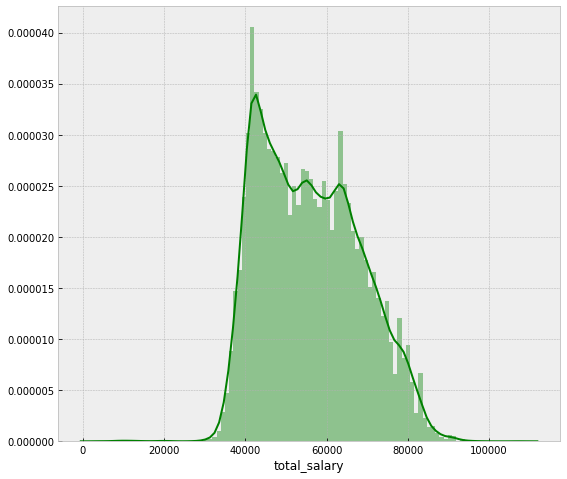

In [45]:
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df_subset['total_salary'], color='g', bins=100, hist_kws={'alpha': 0.4})

In [50]:
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [51]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,research_id,school_year,entity_id,birth_year,contract_days,contract_local_experience,contract_total_experience,total_salary,total_fringe,assignment_work_cesa_number,assignment_fte,school_mailing_zip_code,district_mailing_zip_code,total_compensation
0,114343,2018,NaN,1976,NaN,NaN,NaN,NaN,NaN,2.0,1.0,53575.0,53575,NaN
1,41630,2018,11397.0,1966,191.0,20.0,20.0,77701.0,30023.0,1.0,1.0,53215.0,53201,107724.0
2,40315,2018,657227.0,1979,191.0,1.0,14.0,53817.0,27603.0,7.0,1.0,54302.0,54305,81420.0
3,42517,2018,144407.0,1970,190.0,23.0,23.0,66377.0,10134.0,6.0,1.0,54956.0,54956,76511.0
4,9652,2018,739286.0,1989,190.0,5.0,5.0,39530.0,25719.0,4.0,1.0,54658.0,54624,65249.0


In [0]:
df_num = df_num[['birth_year','contract_days','assignment_fte','contract_local_experience','contract_total_experience']]

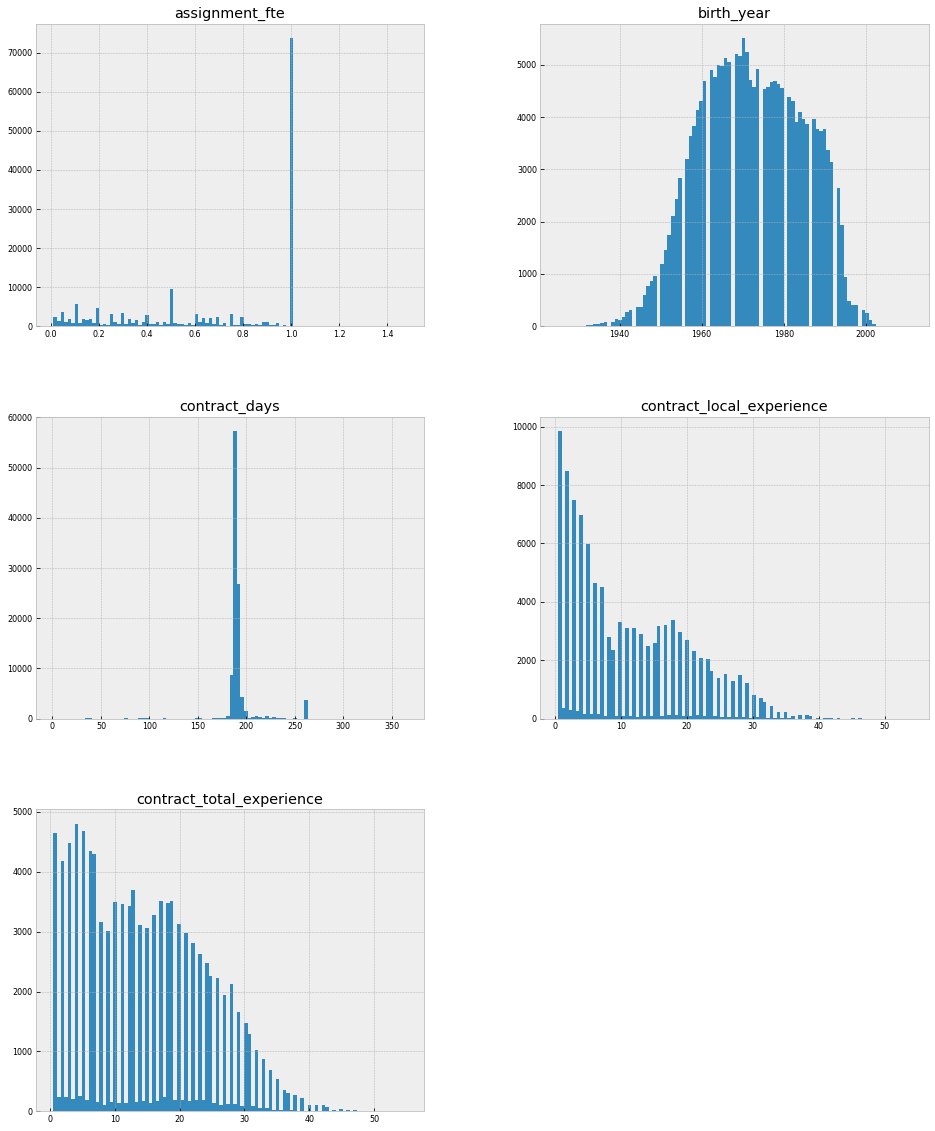

In [53]:
df_num.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

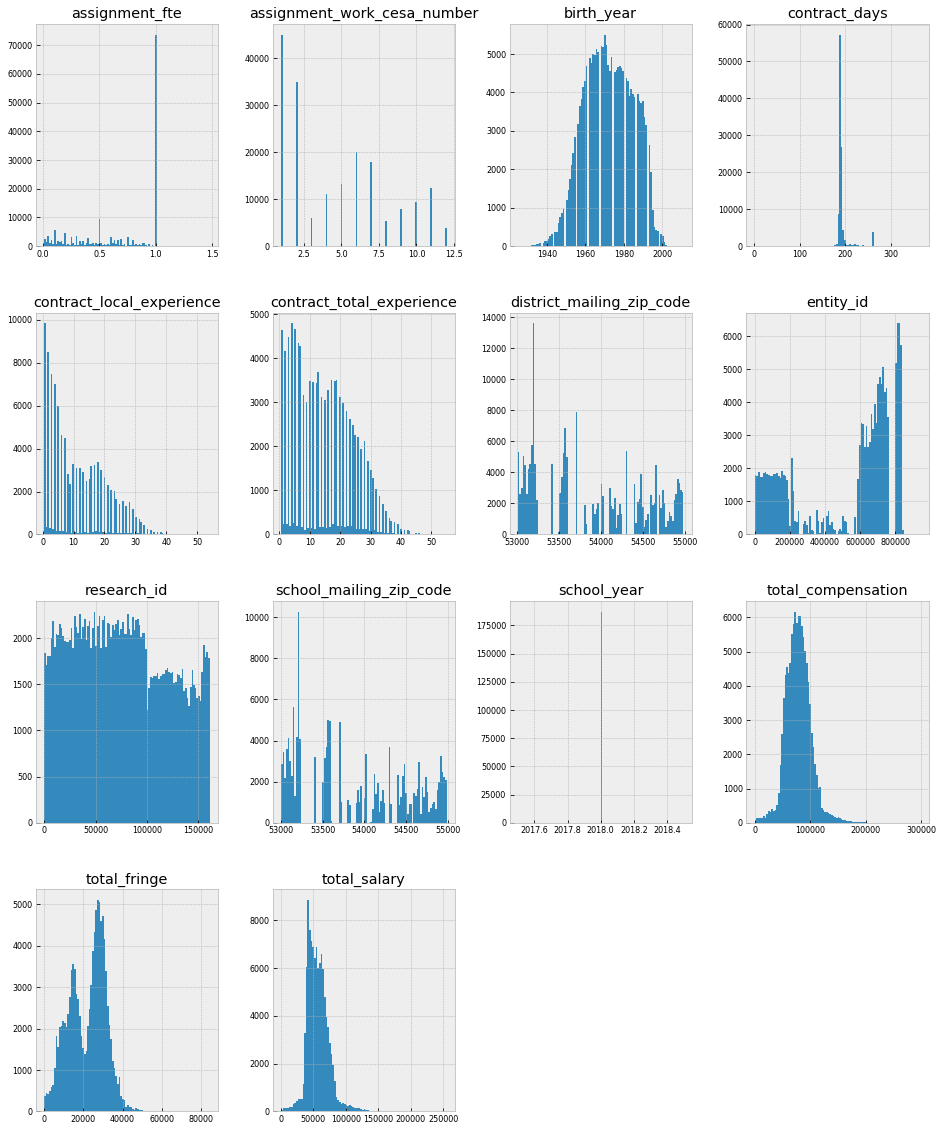

In [54]:
df.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8);

In [55]:
df.corr()

,research_id,school_year,entity_id,birth_year,contract_days,contract_local_experience,contract_total_experience,total_salary,total_fringe,assignment_work_cesa_number,assignment_fte,school_mailing_zip_code,district_mailing_zip_code,total_compensation
research_id,1.000000,NaN,0.066758,-0.239198,-0.009933,-0.031539,0.021667,0.015581,0.022630,0.017359,-0.067817,-0.011821,0.001223,0.020576
school_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
entity_id,0.066758,NaN,1.000000,0.681047,-0.042286,-0.709209,-0.809347,-0.474815,-0.273172,-0.045312,-0.001213,-0.030115,-0.038742,-0.459346
birth_year,-0.239198,NaN,0.681047,1.000000,-0.024200,-0.632348,-0.769329,-0.442206,-0.266246,-0.040547,0.021193,-0.000016,-0.027217,-0.432388
contract_days,-0.009933,NaN,-0.042286,-0.024200,1.000000,0.023293,0.049547,0.533804,0.268626,-0.066314,0.117780,-0.064274,-0.064820,0.500274
contract_local_experience,-0.031539,NaN,-0.709209,-0.632348,0.023293,1.000000,0.826938,0.464103,0.312313,0.023737,0.002538,0.020590,0.018363,0.466835
contract_total_experience,0.021667,NaN,-0.809347,-0.769329,0.049547,0.826938,1.000000,0.538637,0.327731,0.035929,-0.024336,0.029425,0.029783,0.527927
total_salary,0.015581,NaN,-0.474815,-0.442206,0.533804,0.464103,0.538637,1.000000,0.503245,-0.119471,0.131376,-0.157901,-0.143868,0.937364
total_fringe,0.022630,NaN,-0.273172,-0.266246,0.268626,0.312313,0.327731,0.503245,1.000000,0.059947,0.071157,0.020943,0.024752,0.772749
assignment_work_cesa_number,0.017359,NaN,-0.045312,-0.040547,-0.066314,0.023737,0.035929,-0.119471,0.059947,1.000000,-0.111746,0.709349,0.713375,-0.063606


In [0]:
df_corr = df.corr()['total_salary'].drop('total_salary')

In [0]:
golden_features_list = df_corr[abs(df_corr) > 0.5].sort_values(ascending=False)

In [60]:
print("There is {} strongly correlated values with total_salary:\n{}".format(len(golden_features_list), golden_features_list))

There is 4 strongly correlated values with total_salary:
total_compensation           0.937364
contract_total_experience    0.538637
contract_days                0.533804
total_fringe                 0.503245
Name: total_salary, dtype: float64


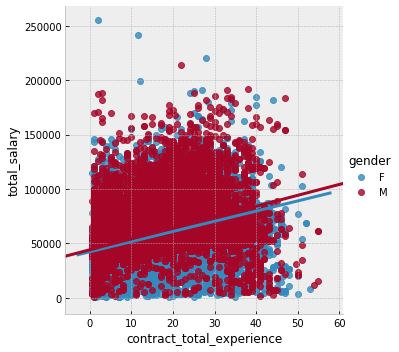

In [62]:
sns.lmplot(x="contract_total_experience",y="total_salary",hue="gender",data=df)

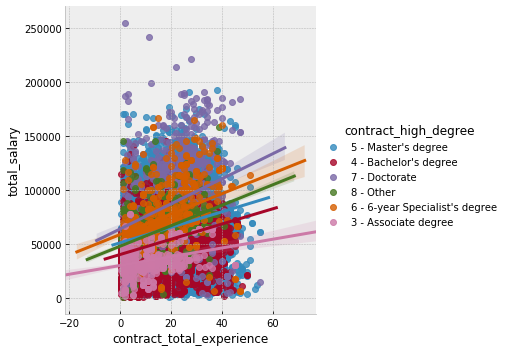

In [63]:
sns.lmplot(x="contract_total_experience",y="total_salary",hue="contract_high_degree",data=df)

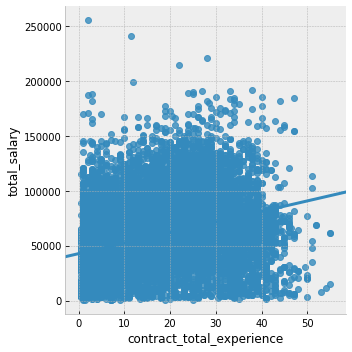

In [64]:
sns.lmplot(x="contract_total_experience",y="total_salary",data=df)

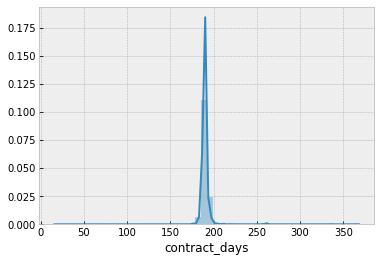

In [65]:
sns.distplot(df_subset['contract_days'])

In [0]:
df_subset['contract_days_median'] = df_subset['contract_days'].median()
df_subset['contract_days_std'] = df['contract_days'].std()

In [0]:
df_subset = df_subset[(df_subset.contract_days <= df_subset['contract_days_median']+3*df_subset['contract_days_std']) & (df_subset.contract_days >= df_subset['contract_days_median']-3*df_subset['contract_days_std'])]

In [70]:
df_subset.describe()

,research_id,school_year,entity_id,birth_year,contract_days,contract_local_experience,contract_total_experience,total_salary,total_fringe,assignment_work_cesa_number,assignment_fte,school_mailing_zip_code,district_mailing_po_box,district_mailing_zip_code,contract_days_median,contract_days_std
count,38130.000000,38130.0,38114.000000,38130.000000,38130.000000,38130.000000,38130.000000,38130.000000,38122.000000,38128.000000,38130.0,37885.000000,8578.000000,38130.000000,38130.0,3.813000e+04
mean,59020.213533,2018.0,514459.584667,1975.581773,189.860110,12.016418,14.496132,55951.459271,22381.025209,4.493338,1.0,53849.585905,6887.788645,53846.512352,190.0,1.873397e+01
std,36382.353605,0.0,279929.010456,10.430151,3.217829,9.036582,9.287395,12196.819433,8671.849080,3.366456,0.0,653.653005,47378.611315,650.949362,0.0,1.083592e-12
min,1.000000,2018.0,4.000000,1939.000000,134.000000,0.500000,0.500000,27644.000000,838.000000,1.000000,1.0,53002.000000,6.000000,53008.000000,190.0,1.873397e+01
25%,30452.750000,2018.0,186121.500000,1967.000000,188.000000,4.000000,6.000000,45352.250000,14805.000000,1.000000,1.0,53204.000000,190.000000,53201.000000,190.0,1.873397e+01
50%,56715.000000,2018.0,647528.500000,1976.000000,190.000000,10.000000,14.000000,55000.000000,24645.000000,4.000000,1.0,53704.000000,1830.000000,53703.000000,190.0,1.873397e+01
75%,82238.750000,2018.0,727292.000000,1984.000000,191.000000,19.000000,21.000000,65000.000000,29105.000000,7.000000,1.0,54455.000000,2181.000000,54452.000000,190.0,1.873397e+01
max,161064.000000,2018.0,840493.000000,1996.000000,244.000000,51.000000,52.000000,107400.000000,82204.000000,12.000000,1.0,54986.000000,700100.000000,54986.000000,190.0,1.873397e+01


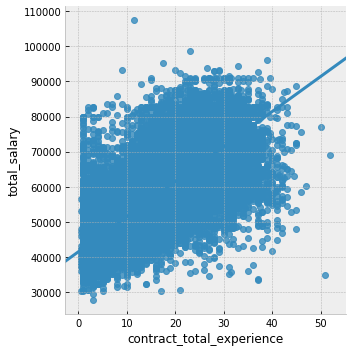

In [71]:
sns.lmplot(x="contract_total_experience",y="total_salary",data=df_subset)

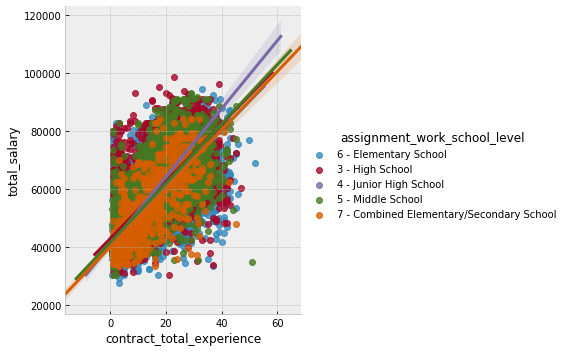

In [72]:
sns.lmplot(x="contract_total_experience",y="total_salary",hue="assignment_work_school_level", data=df_subset)

In [0]:
df_masters = df_subset[(df_subset['contract_high_degree']=="4 - Bachelor's degree") | (df_subset['contract_high_degree']=="5 - Master's degree")]

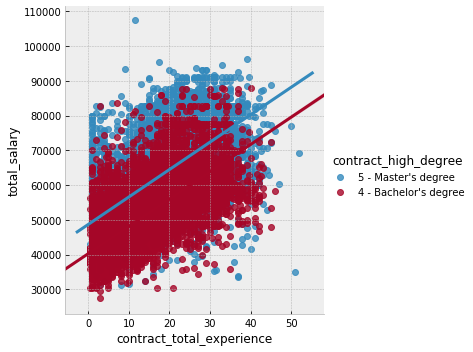

In [74]:
sns.lmplot(x="contract_total_experience",y="total_salary",hue="contract_high_degree", data=df_masters)

In [0]:
ave_salary = df_masters.groupby(['assignment_work_agency']).mean()['total_salary']


In [101]:
ave_salary.sort_values(ascending=False)

assignment_work_agency
2177 - Nicolet UHS School District                    77189.173913
3510 - Swallow School District                        69941.869565
2450 - Arrowhead UHS School District                  69498.300000
6545 - Wilmot UHS School District                     68704.111111
0714 - Elmbrook School District                       67316.734375
5859 - Union Grove J1 School District                 67216.230769
1890 - Fox Point J2 School District                   67134.911765
4018 - Oak Creek-Franklin Joint School District       66852.857143
3857 - Muskego-Norway School District                 66647.846890
1900 - Franklin Public School District                65988.693548
                                                          ...     
6354 - Weston School District                         40717.400000
8137 - United Community Center Acosta MiddleSchool    40633.666667
3427 - Mellen School District                         40265.428571
2415 - Gresham School District         

# Analysis

Created dataset wi-dpi-010.refined


1it [00:01,  1.73s/it]


## Load Data